# QF605 Fixed-Income Securities
## Part 2 - Swaption Calibration
#### Prepared by: Zhang Shuxin, Jiang Shuang, Ong Shi Xin, Victor Kow, Wang Bo, Ankit Rawat, Sun Jianyun

In [55]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq, fsolve
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

In [56]:
swaption = pd.read_excel ('IR Data.xlsx', sheet_name='Swaption', skiprows = 2, header = 0)
swaption = swaption.iloc[0:15,0:13]
swaption.iloc[:, 2:] = swaption.iloc[:, 2:] / 100

In [57]:
swap = swaption.set_index(['Expiry', 'Tenor'])

In [58]:
bps = np.array([0 if i == 7 else float(swaption.columns[i][0:-3]) / 10000
       for i in range(2, len(swaption.columns))])

In [59]:
# Forward Swap Rates derived from from part I
fsr = pd.read_csv('forward_swap_rate.csv', header = 0, index_col = 0)
fsr

,1Y,2Y,3Y,5Y,10Y
1Y,0.032007,0.033259,0.034011,0.035255,0.038428
5Y,0.039274,0.040075,0.040072,0.041093,0.043634
10Y,0.042189,0.043116,0.044097,0.046249,0.053458


In [60]:
semi_annual_DF = pd.read_csv('discount_factor.csv', header = 0, index_col = 0).reset_index()

In [61]:
yearly_DF = pd.read_csv('yearly_DF.csv', header = 0, index_col = 0)

In [62]:
semi_annual_DF

,Tenor,OIS_DF,Libor_DF
0,0.5,0.998752,0.987654
1,1.0,0.997009,0.972577
2,1.5,0.995270,0.957378
3,2.0,0.993531,0.942179
4,2.5,0.991773,0.926330
5,3.0,0.990015,0.910482
6,3.5,0.988066,0.894731
7,4.0,0.986117,0.878981
8,4.5,0.984150,0.863985
9,5.0,0.982184,0.848989


In [63]:
def Black76Call(F, K, sigma, pvbp, T):
    d1 = (np.log(F/K) + 1/2 *(sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return pvbp*(F*norm.cdf(d1) - K*norm.cdf(d2))

def Black76Put(F, K, sigma, pvbp, T):
    d1 = (np.log(F/K) + 1/2 * sigma**2*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return pvbp*(K*norm.cdf(-d2) - F*norm.cdf(-d1))

def DD_Call(F, K, sigma, pvbp, beta, T):
    F_d = F/beta
    K_d = K + ((1-beta)/beta)*F
    sigma_d = sigma*beta
    
    dd_option = Black76Call(F_d, K_d, sigma_d, pvbp, T)
    
    return dd_option

def DD_Put(F, K, sigma, pvbp, beta, T):
    F_d = F/beta
    K_d = K + ((1-beta)/beta)*F
    sigma_d = sigma*beta
    
    dd_option = Black76Put(F_d, K_d, sigma_d, pvbp, T)
    
    return dd_option

In [64]:
def Black76(F, K, sigma, pvbp, T):
    d1 = (np.log(F/K) + 1/2 *(sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if F <= K:
        black_price =  pvbp*(F*norm.cdf(d1) - K*norm.cdf(d2))
    else:
        black_price =  pvbp*(K*norm.cdf(-d2) - F*norm.cdf(-d1))
    return black_price


def DD(F, K, sigma, pvbp, beta, T):
    if F <= K:
        F_d = F/beta
        K_d = K + ((1-beta)/beta)*F
        sigma_d = sigma*beta
        
        price = Black76Call(F_d, K_d, sigma_d, pvbp, T)
    
    else:
        F_d = F/beta
        K_d = K + ((1-beta)/beta)*F
        sigma_d = sigma*beta
        
        price = Black76Put(F_d, K_d, sigma_d, pvbp, T)
        
    return price

In [65]:
def volatility(F, K, pvbp, T, sigma, beta):
    
    #price = DD(F, K, sigma, pvbp, beta, T)
    
    if F <= K:
        price = DD_Call(F, K, sigma, pvbp, beta, T)
        vol = fsolve(lambda x: price -
                        Black76Call(F, K, x, pvbp, T),
                        0.5)
    else:
        price = DD_Put(F, K, sigma, pvbp, beta, T)
        vol = fsolve(lambda x: price -
                        Black76Put(F, K,x,pvbp, T),
                        0.5)
    return vol[0]

In [66]:
def ddcalibration(x,  F, strikes, vols, pvbp,  T):
    err = 0.0
    sigma = vols[5]
    
    for i, vol in enumerate(vols):
        
        err += (vol - volatility( F, strikes[i], pvbp,  T, sigma, x))**2

    return err

### 1. DD Model Calibration

In [67]:
Expiry=['1Y','5Y','10Y']
Tenor=['1Y','2Y','3Y','5Y','10Y']

In [68]:
initialGuess = [0.3]

In [69]:
Cal_Beta=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)
Cal_Sigma=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)

In [70]:
for ex in Expiry:
    for te in Tenor:
        fwd = fsr.loc[ex, te]
        market_vol = swap.loc[(ex, te), :].values
        strikes = fwd + bps
        
        ex_int = int(ex.strip()[:-1])
        te_int = int(te.strip()[:-1])
        pvbp = 0.5 * sum(semi_annual_DF.OIS_DF[2*ex_int:(ex_int+te_int)*2])
        
        res = least_squares(lambda x: ddcalibration(x, fwd, strikes, 
                                                    market_vol, pvbp, T = ex_int), initialGuess,
                                                    bounds=([0,1]))
        
        Cal_Beta[te][ex]= res.x
        Cal_Sigma[te][ex]= market_vol[5]

In [71]:
Cal_Sigma

,1Y,2Y,3Y,5Y,10Y
1Y,0.2250,0.2872,0.2978,0.2607,0.2447
5Y,0.2726,0.2983,0.2998,0.2660,0.2451
10Y,0.2854,0.2928,0.2940,0.2674,0.2437


In [72]:
Cal_Beta

,1Y,2Y,3Y,5Y,10Y
1Y,3.687890e-08,8.148281e-14,3.891307e-07,1.475881e-10,0.000007
5Y,1.310269e-11,5.503210e-08,2.277114e-06,1.432631e-04,0.055462
10Y,1.396061e-07,7.489292e-06,8.155062e-05,1.387962e-06,0.001745


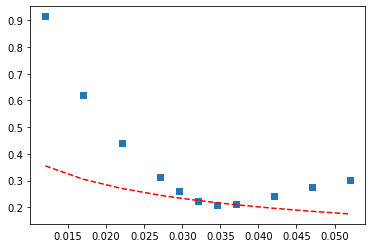

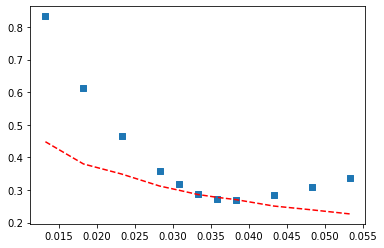

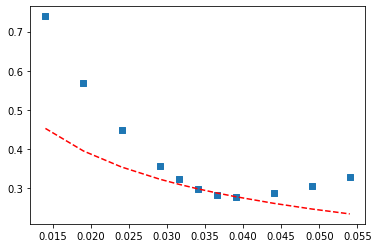

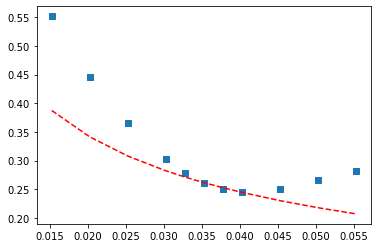

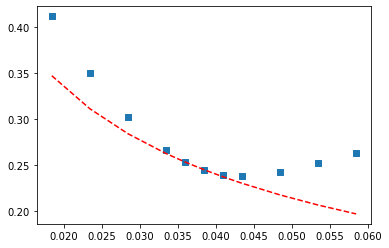

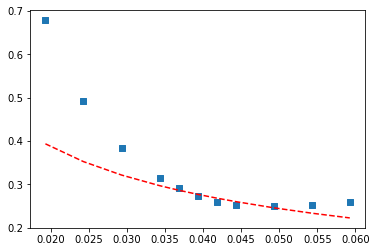

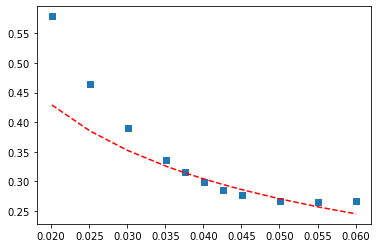

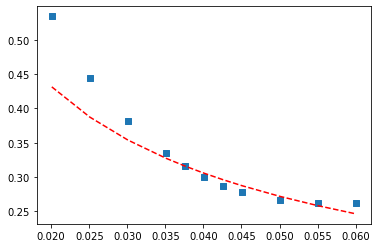

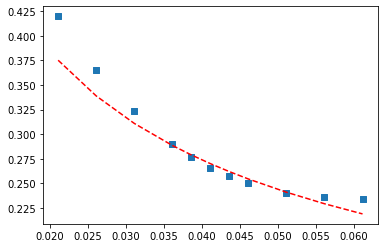

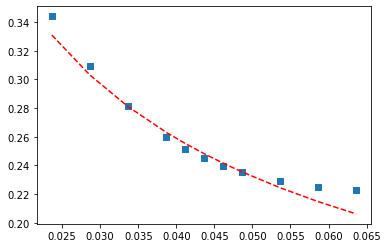

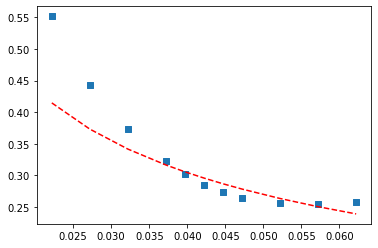

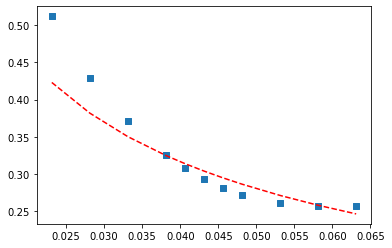

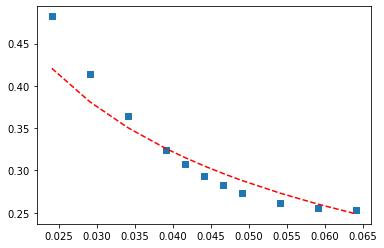

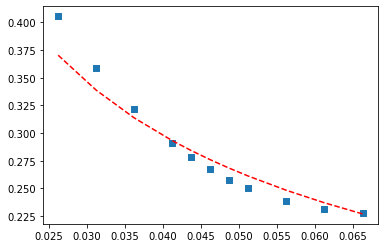

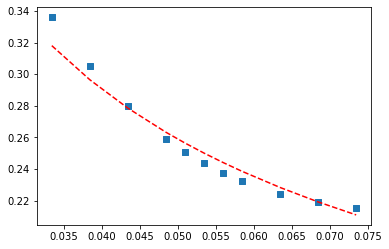

In [73]:
# plot the calibrated DD model with the market vols 
for ex in Expiry:
    for te in Tenor:
        fwd = fsr.loc[ex, te]
        market_vols = swap.loc[(ex, te), :].values
        strikes = fwd + bps
        
        ex_int = int(ex.strip()[:-1])
        te_int = int(te.strip()[:-1])
        pvbp = 0.5 * sum(semi_annual_DF.OIS_DF[2*ex_int:(ex_int+te_int)*2])
        T = ex_int
        
        DD_vols = [volatility(fwd, i, pvbp, T, Cal_Sigma.loc[ex,te], Cal_Beta.loc[ex, te]) 
                   for i in strikes]
        
        plt.figure()
        plt.scatter(strikes, market_vols,marker = 's')
        plt.plot(strikes, DD_vols, '--r')

### 2. SABR calibration

In [74]:
beta = 0.9

In [75]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    if F == K:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom
    return sabrsigma

def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2
    return err

In [76]:
SABR_Alpha=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)
SABR_Rho=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)
SABR_Nu=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)

In [77]:
initialGuess_sabr=[0.1,-0.5,0.5]

In [78]:
for ex in Expiry:
    for te in Tenor:             #Set sigma,T,ATM,strikes
        fwd = fsr.loc[ex, te]
        market_vol = swap.loc[(ex, te), :].values
        strikes = fwd + bps
    
        T=int(ex[:-1])
       
        res=least_squares(lambda x: sabrcalibration(x,
                                           strikes,
                                           market_vol,
                                           fwd,
                                           T),
                          initialGuess_sabr,
                          bounds=([0,-1,0],[np.inf,1,np.inf]))
        SABR_Alpha[te][ex]=res.x[0]
        SABR_Rho[te][ex]=res.x[1]
        SABR_Nu[te][ex]=res.x[2]

In [79]:
SABR_Alpha

,1Y,2Y,3Y,5Y,10Y
1Y,0.139070,0.184649,0.196850,0.178052,0.171151
5Y,0.166532,0.199498,0.210256,0.191125,0.177184
10Y,0.177533,0.195216,0.207121,0.201610,0.181153


In [80]:
SABR_Rho

,1Y,2Y,3Y,5Y,10Y
1Y,-0.633211,-0.525117,-0.482845,-0.414426,-0.264779
5Y,-0.585168,-0.546877,-0.549411,-0.511652,-0.438724
10Y,-0.545807,-0.544358,-0.550638,-0.562790,-0.511985


In [81]:
SABR_Nu

,1Y,2Y,3Y,5Y,10Y
1Y,2.049441,1.677413,1.438147,1.064877,0.777785
5Y,1.339647,1.061912,0.936615,0.671289,0.495764
10Y,1.007239,0.925448,0.868935,0.719956,0.577963


In [82]:
def sabrvol(F, K, pvbp, T, alpha, beta, rho, nu):
    
    sigma = SABR(F, K, T, alpha, beta, rho, nu)
    if F <= K:
        price = Black76Call(F, K, sigma, pvbp, T)
        vol = fsolve(lambda x: price -
                        Black76Call(F, K, x, pvbp, T),
                        0.5)
    else:
        price = Black76Put(F, K, sigma, pvbp, T)
        vol = fsolve(lambda x: price -
                        Black76Put(F, K,x,pvbp, T),
                        0.5)
    return vol[0]

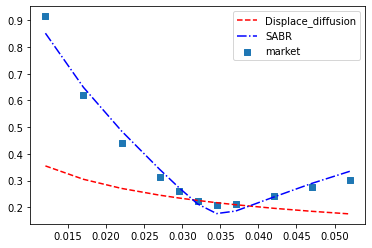

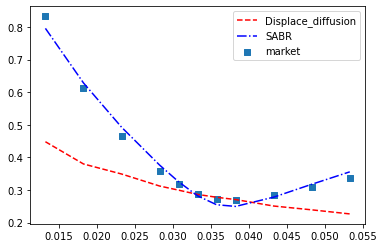

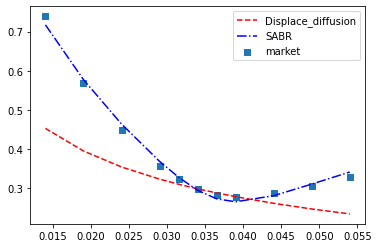

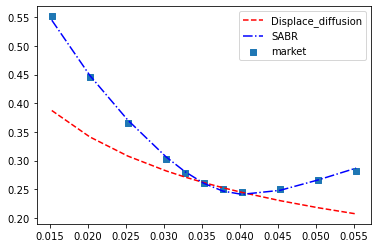

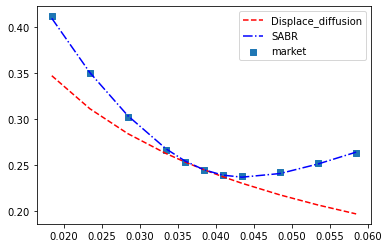

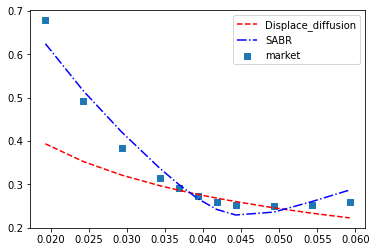

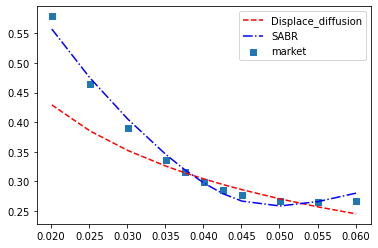

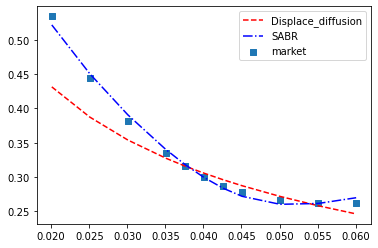

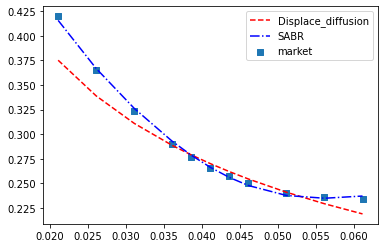

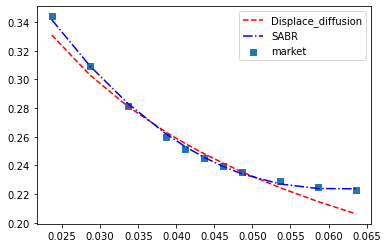

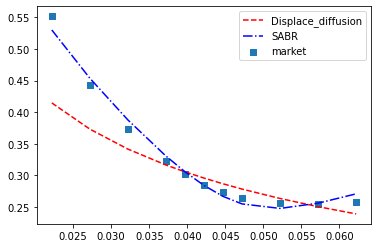

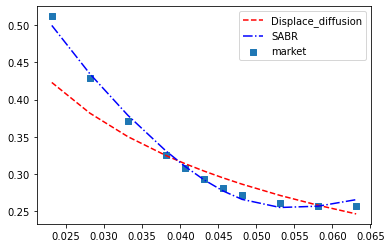

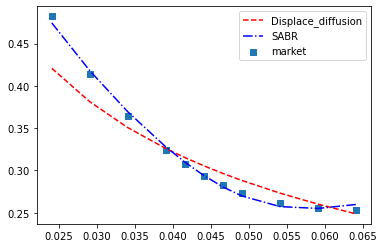

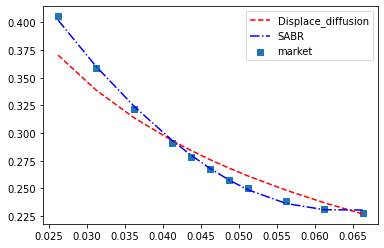

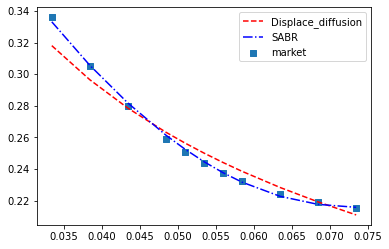

In [83]:
# plot the DD model and SABR model
for ex in Expiry:
    for te in Tenor:
        fwd = fsr.loc[ex, te]
        market_vols = swap.loc[(ex, te), :].values
        strikes = fwd + bps
        
        ex_int = int(ex.strip()[:-1])
        te_int = int(te.strip()[:-1])
        pvbp = 0.5 * sum(semi_annual_DF.OIS_DF[2*ex_int:(ex_int+te_int)*2])
        T = ex_int
        
        DD_vols = [volatility(fwd, i, pvbp, T, Cal_Sigma.loc[ex,te], Cal_Beta.loc[ex, te]) 
                   for i in strikes]
        SABR_vols = [sabrvol(fwd, i, pvbp, T, SABR_Alpha.loc[ex,te], 0.9,
                             SABR_Rho.loc[ex, te], SABR_Nu.loc[ex, te]) for i in strikes]
        
        plt.figure()
        plt.scatter(strikes, market_vols,marker = 's', label= 'market')
        plt.plot(strikes, DD_vols, '--r', label = 'Displace_diffusion')
        plt.plot(strikes, SABR_vols, '-.b', label = 'SABR')
        plt.legend()

In [84]:
SABR_Alpha.to_csv('sabr_alpha.csv')
SABR_Rho.to_csv('sabr_rho.csv')
SABR_Nu.to_csv('sabr_nu.csv')

### 3. Swaption Pricing using calibrated DD and SABR model

In [85]:
def interpol(x1,y1,x2,y2,x):
    return y1+(x-x1)*((y2-y1)/(x2-x1))

In [86]:
sigma = interpol(1,Cal_Sigma['10Y']['1Y'],5,Cal_Sigma['10Y']['5Y'],2)
beta = interpol(1,Cal_Beta['10Y']['1Y'],5,Cal_Beta['10Y']['5Y'],2)

In [87]:
alpha=interpol(1,SABR_Alpha['10Y']['1Y'],5,SABR_Alpha['10Y']['5Y'],2)
rho=interpol(1,SABR_Rho['10Y']['1Y'],5,SABR_Rho['10Y']['5Y'],2)
nu=interpol(1,SABR_Nu['10Y']['1Y'],5,SABR_Nu['10Y']['5Y'],2)

In [88]:
# for payer 2y x 10y

#from Part I, recall:
#deno = 0.5*sum(df.OIS_DF[2*2:2*(2+10)])  
# terms = []
# for x in range(2*2, 2*(2+10)):
#     no = df.OIS_DF[x] * (df.Libor_DF[x-1] - df.Libor_DF[x])/df.Libor_DF[x]
#     terms.append(no)
# numer = sum(terms)
# fwd1 = numer/deno

fwd1 = 0.03963437677316925
strikes=np.arange(0.01,0.081,0.01)
T = 2
pvbp1 = 0.5 * sum(semi_annual_DF.OIS_DF[2*2:(2+10)*2])
pvbp1

9.699535688510334

In [89]:
payer_DD = [DD_Call(fwd1, i, sigma, pvbp1, beta, T) for i in strikes]    

In [90]:
payer_SABR=[Black76Call(fwd1,i,SABR(fwd1,i,T,alpha,0.9,rho,nu),pvbp1, T) for i in strikes]

In [91]:
payer = pd.DataFrame({'Strikes':strikes, 'Displaced Diffusion':payer_DD,
                     'SABR': payer_SABR})
payer

,Strikes,Displaced Diffusion,SABR
0,0.01,0.288142,0.289608
1,0.02,0.194936,0.198315
2,0.03,0.112326,0.115202
3,0.04,0.051345,0.052176
4,0.05,0.017366,0.021382
5,0.06,0.004106,0.010739
6,0.07,0.000651,0.006616
7,0.08,0.000067,0.004635


In [92]:
# for receiver 8x10y

# From Part I, recall:
# deno = 0.5*sum(df.OIS_DF[2*8:2*(8+10)])
# terms = []
# for x in range(2*8, 2*(8+10)):
#     no = df.OIS_DF[x] * (df.Libor_DF[x-1] - df.Libor_DF[x])/df.Libor_DF[x]
#     terms.append(no)
# numer = sum(terms)
# fwd2 = numer/deno

fwd2 = 0.04871114894211796
pvbp2 = 0.5 * sum(semi_annual_DF.OIS_DF[8*2:(8+10)*2])
T = 8
pvbp2

9.375969869808888

In [93]:
sigma = interpol(5,Cal_Sigma['10Y']['5Y'],10,Cal_Sigma['10Y']['10Y'],8)
beta = interpol(5,Cal_Beta['10Y']['5Y'],10,Cal_Beta['10Y']['10Y'],8)

In [94]:
alpha=interpol(5,SABR_Alpha['10Y']['5Y'],10,SABR_Alpha['10Y']['10Y'],8)
rho=interpol(5,SABR_Rho['10Y']['5Y'],10,SABR_Rho['10Y']['10Y'],8)
nu=interpol(5,SABR_Nu['10Y']['5Y'],10,SABR_Nu['10Y']['10Y'],8)

In [95]:
rec_DD = [DD_Put(fwd2, i, sigma, pvbp2, beta, T) for i in strikes]
rec_SABR=[Black76Put(fwd2, i, SABR(fwd2,i,T,alpha,0.9,rho,nu), pvbp2, T) for i in strikes]

In [96]:
receiver = pd.DataFrame({'Strikes':strikes, 'Displaced Diffusion':rec_DD,
                     'SABR': rec_SABR})
receiver

,Strikes,Displaced Diffusion,SABR
0,0.01,0.018985,0.019245
1,0.02,0.033904,0.038450
2,0.03,0.056649,0.061176
3,0.04,0.088980,0.090324
4,0.05,0.132050,0.130387
5,0.06,0.186136,0.186140
6,0.07,0.250582,0.257321
7,0.08,0.323971,0.338493


In [97]:
#exit()